In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = yf.Ticker('ETH-USD')
df = ticker.history(start='2017-11-09', end='2024-12-31')
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
1,2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2,2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
3,2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
4,2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0


In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

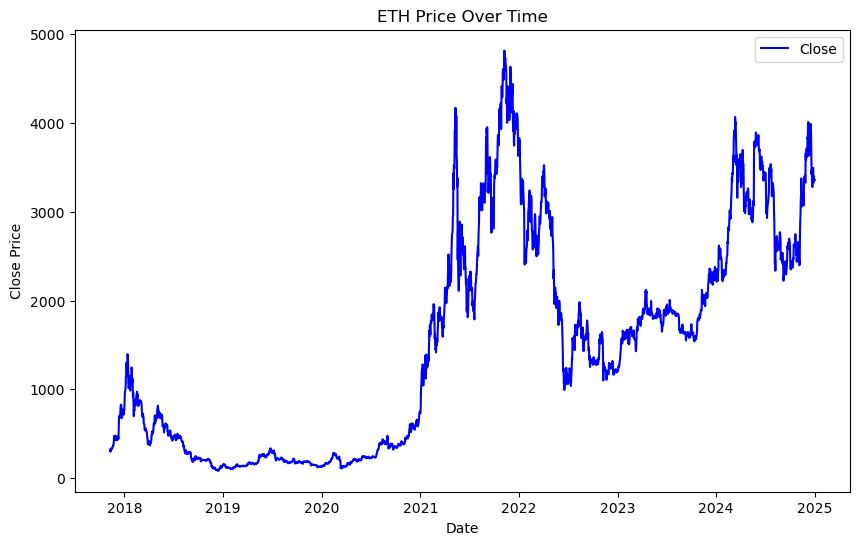

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.title('ETH Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show();

In [5]:
# MACD
def compute_macd(data, short=12, long=26, signal=9):
    ema_short = data['Close'].ewm(span=short, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long, adjust=False).mean()

    # MACD line
    macd = ema_short - ema_long

    # Signal line (EMA of MACD)
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    data['MACD'] = macd
    data['Signal'] = signal_line

    return data

df = compute_macd(df)

In [6]:
# RSI
def compute_rsi(data, period=14):
    delta = data['Close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

df = compute_rsi(df)

In [7]:
# Bollinger Bands
def compute_bollinger_bands(data, period=20, std_multiplier=2):
    sma = data['Close'].rolling(window=period).mean()
    std = data['Close'].rolling(window=period).std()

    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    data['BB_Middle'] = sma
    data['BB_Upper'] = upper_band
    data['BB_Lower'] = lower_band

    return data

df = compute_bollinger_bands(df)

In [8]:
# Moving Average
def compute_ma(data, period=20):
    data[f'SMA_{period}'] = data['Close'].rolling(window=period).mean()
    return data
    
df = compute_ma(df)

In [9]:
df['Lag3'] = df['Close'].shift(3)

In [10]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag3
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0,-1.725551,-0.345110,0.000000,NaN,NaN,NaN,NaN,NaN
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0,-1.827089,-0.641506,45.144288,NaN,NaN,NaN,NaN,NaN
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0,-2.426118,-0.998428,36.742192,NaN,NaN,NaN,NaN,320.884003
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0,-2.165161,-1.231775,50.551754,NaN,NaN,NaN,NaN,299.252991


In [11]:
df.dropna(inplace=True)
df = df.drop(['Dividends','Stock Splits'],axis=1)

In [12]:
df.shape

(2590, 14)

In [13]:
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag3
0,2017-11-28,480.518005,482.480011,466.346985,472.902008,1346499968,39.757338,25.986437,82.053111,373.973451,502.178044,245.768858,373.973451,466.276001
1,2017-11-29,473.281006,522.307007,425.071014,427.523010,2675940096,37.185784,28.226306,54.739286,379.305402,507.082721,251.528082,379.305402,471.329987
2,2017-11-30,431.214996,465.497009,401.243011,447.114014,1903040000,36.310079,29.843061,61.176931,386.698453,512.061027,261.335879,386.698453,480.355011
3,2017-12-01,445.209015,472.609009,428.312012,466.540009,1247879936,36.759847,31.226418,66.610552,394.291403,519.683448,268.899358,394.291403,472.902008
4,2017-12-02,466.851013,476.239014,456.653015,463.449005,943649984,36.446739,32.270482,64.941815,402.068454,524.152173,279.984735,402.068454,427.523010


In [14]:
df = df.set_index('Date')

In [15]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

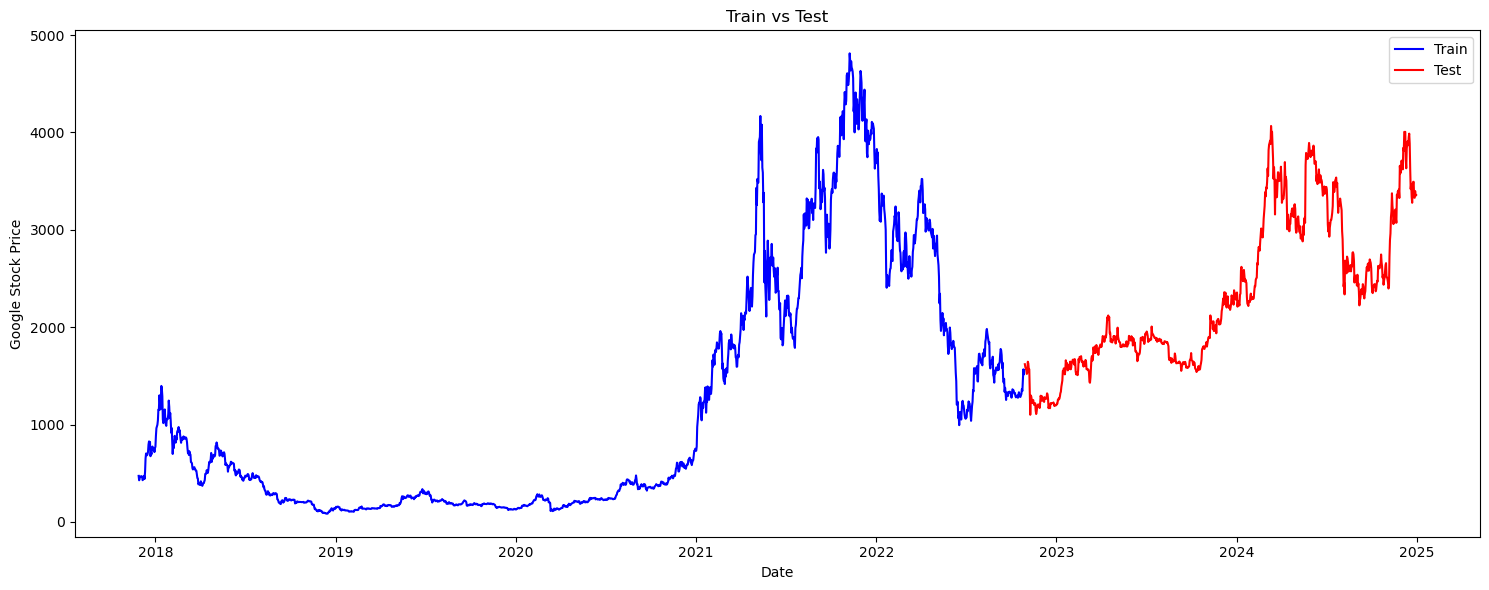

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
# training data
sns.lineplot(x=df.index[:1796], y=df['Close'][:1796], color='blue', label='Train', ax=ax)
# testing data
sns.lineplot(x=df.index[1796:], y=df['Close'][1796:], color='red', label='Test', ax=ax)

ax.set_title('Train vs Test')
ax.set_xlabel('Date')
ax.set_ylabel('Google Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [17]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [18]:
def create_sequence(data, window=3):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window, 3])
    return np.array(x), np.array(y)

In [19]:
x_train, y_train = create_sequence(train_scaled, window=3)
x_test, y_test = create_sequence(test_scaled, window=3)

In [20]:
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

<h2>Machine Learning</h2>

In [21]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train_2d, y_train)
y_pred = model.predict(x_test_2d)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared:", r2_score(y_test, y_pred))

MAE: 0.01673918259654421
RMSE: 0.02336016152082706
R-squared: 0.9752547426930369


In [22]:
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred 

y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

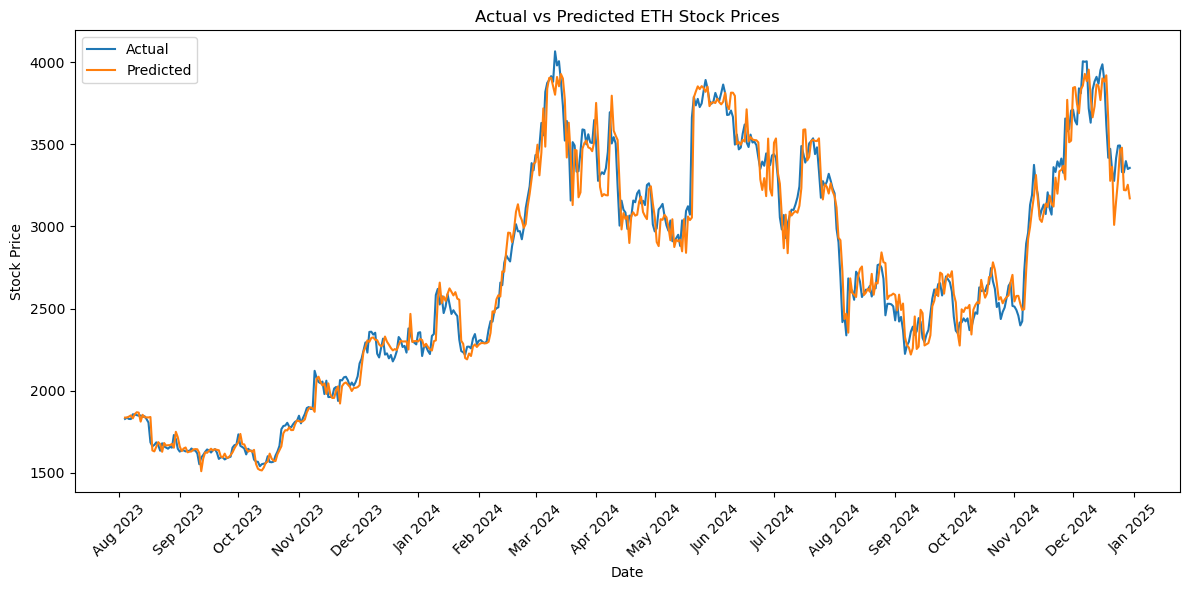

In [23]:
window=3
test_dates = test_df.index[window:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')

# Format the x-axis to show dates monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Actual vs Predicted ETH Stock Prices')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [24]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df.head()

,Actual,Predicted
Date,,
2023-08-04,1827.712891,1835.735491
2023-08-05,1834.987915,1836.226959
2023-08-06,1827.462036,1841.808750
2023-08-07,1826.938843,1848.997295
2023-08-08,1855.807373,1831.308164


<h2>Deep Learning</h2>

In [25]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True)),
model.add(LSTM(units=64, activation='relu')),
model.add(Dropout(0.1)),
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=20, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - loss: 0.0274 - mae: 0.0936 - val_loss: 0.0017 - val_mae: 0.0334
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0014 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0242
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 8.6644e-04 - val_mae: 0.0217
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0012 - mae: 0.0218 - val_loss: 7.9702e-04 - val_mae: 0.0207
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0013 - mae: 0.0214 - val_loss: 9.1402e-04 - val_mae: 0.0232
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 9.9743e-04 - mae: 0.0198 - val_loss: 0.0018 - val_mae: 0.0332
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 8.0330e-04 - val_mae: 0.0215
Epoch 9/20
207/207 ━━━━━━━━

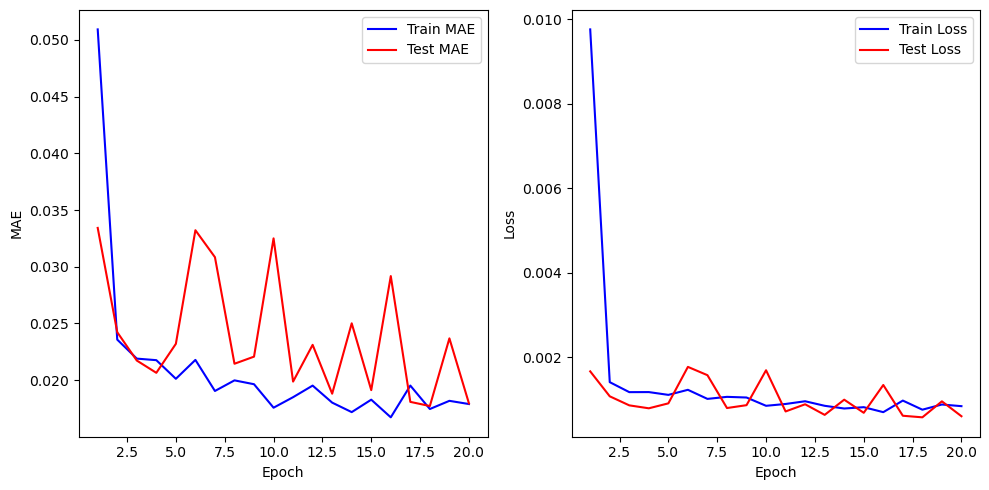

In [26]:
# learning curve
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, mae, 'b', label='Train MAE')
axes[0].plot(epochs, val_mae, 'r', label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# adusting layout for better spacing
plt.tight_layout()
# display the figure
plt.show();

In [27]:
# Predict
y_pred = model.predict(x_test).flatten()

window=3
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred
y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

test_dates = test_df.index[window:]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [28]:
print("MAE:", mean_absolute_error(y_test_original, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))
print("R²:", r2_score(y_test_original, y_pred_original))

MAE: 84.91292357415021
RMSE: 116.71523779288233
R²: 0.9723636263510118


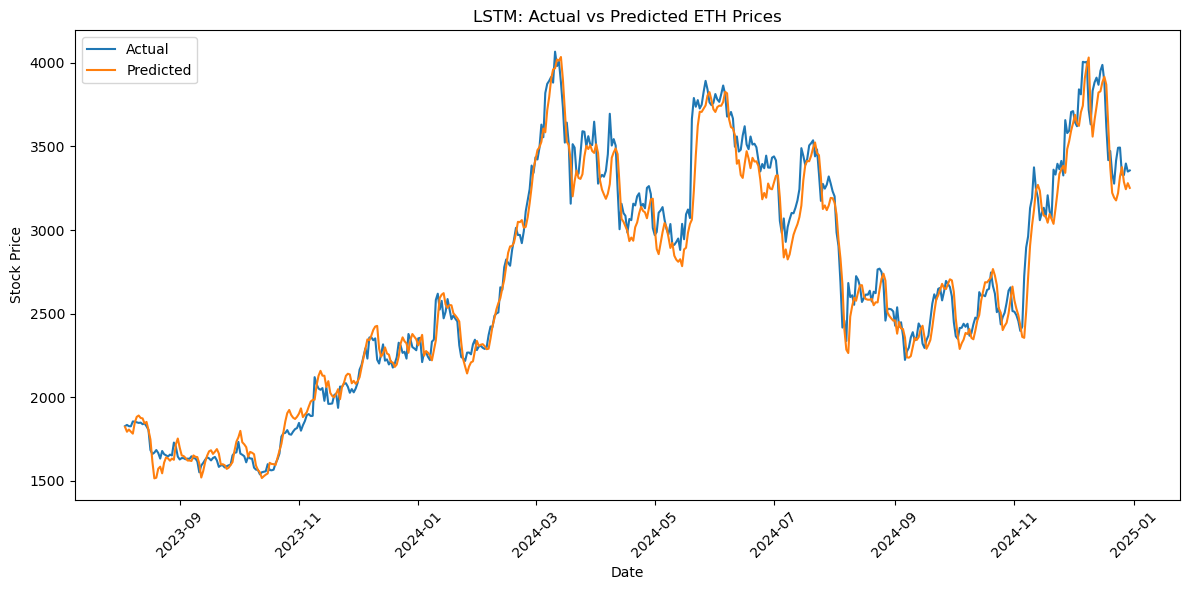

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')
plt.xticks(rotation=45)
plt.title('LSTM: Actual vs Predicted ETH Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [30]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df.head()

,Actual,Predicted
Date,,
2023-08-04,1827.712891,1823.235035
2023-08-05,1834.987915,1794.363604
2023-08-06,1827.462036,1807.465783
2023-08-07,1826.938843,1794.556917
2023-08-08,1855.807373,1782.917126
